In [34]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
df=pd.read_csv('training_100.csv')
df['timestamp']=pd.to_datetime(df['timestamp'])
df.head() 

timestamp  kpi_value  request_count  anomaly_label
0 2020-08-14 02:00:00+02:00   0.998755          24908              0
1 2020-08-14 02:01:00+02:00   0.997683          25029              0
2 2020-08-14 02:02:00+02:00   0.998341          24115              0
3 2020-08-14 02:03:00+02:00   0.998211          24031              0
4 2020-08-14 02:04:00+02:00   0.998403          23790              0

[Time Series of Price Anomaly Detection with LSTM](https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9)

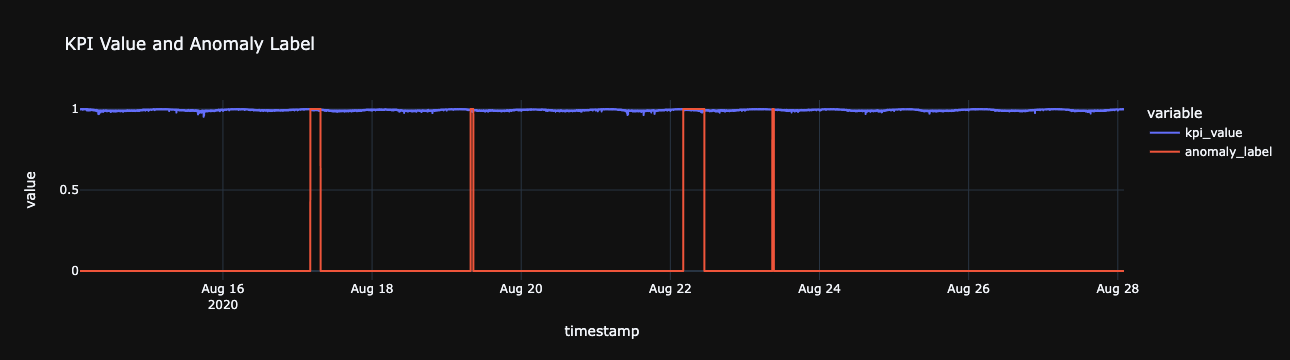

In [35]:
import plotly.express as px
fig = px.line(df, x="timestamp", y=['kpi_value', 'anomaly_label'], title='KPI Value and Anomaly Label', template='plotly_dark')
fig.show()

In [36]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2020-08-14 02:00:00+0200', tz='pytz.FixedOffset(120)'),
 Timestamp('2020-08-28 02:00:00+0200', tz='pytz.FixedOffset(120)'))

In [37]:
time=df['timestamp']
time_point=time[round(len(df)*0.8)]
time_point

Timestamp('2020-08-25 06:47:00+0200', tz='pytz.FixedOffset(120)')

In [38]:
train, test = df.loc[df['timestamp'] <= time_point], df.loc[df['timestamp'] > time_point]
train.shape, test.shape

((16128, 4), (4031, 4))

In [39]:
scaler = StandardScaler()
scaler = scaler.fit(train[['kpi_value']])

train['kpi_value'] = scaler.transform(train[['kpi_value']])
test['kpi_value'] = scaler.transform(test[['kpi_value']])

/var/folders/vj/779818pj4tz4xwpyg2yk0mq00000gn/T/ipykernel_53570/936988913.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vj/779818pj4tz4xwpyg2yk0mq00000gn/T/ipykernel_53570/936988913.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps): #Should reach max-time_step since anything after that would not predict correctly. Final iteration train from [len(X)-time_steps] until [len(X)-1], then use len(X) to predict the last value
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['kpi_value']], train['kpi_value'])
X_test, y_test = create_sequences(test[['kpi_value']], test['kpi_value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (16098, 30, 1)
Testing shape: (4001, 30, 1)


In [41]:
model = Sequential()
model.add(LSTM(32, batch_input_shape=(None, X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
453/453 [==============================] - 5s 8ms/step - loss: 0.2960 - val_loss: 0.2024
Epoch 2/100
453/453 [==============================] - 4s 8ms/step - loss: 0.2646 - val_loss: 0.1969
Epoch 3/100
453/453 [==============================] - 3s 8ms/step - loss: 0.2606 - val_loss: 0.1967
Epoch 4/100
453/453 [==============================] - 3s 8ms/step - loss: 0.2592 - val_loss: 0.1960
Epoch 5/100
453/453 [==============================] - 3s 8ms/step - loss: 0.2587 - val_loss: 0.1960
Epoch 6/100
453/453 [==============================] - 3s 8ms/step - loss: 0.2575 - val_loss: 0.1971
Epoch 7/100
453/453 [==============================] - 4s 8ms/step - loss: 0.2570 - val_loss: 0.1973


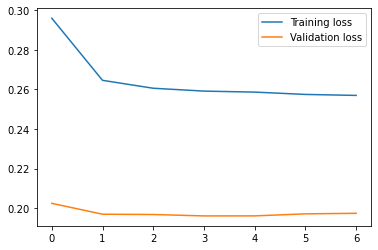

In [43]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [44]:
model.evaluate(X_test, y_test)

126/126 [==============================] - 0s 2ms/step - loss: 0.2098


0.20982250571250916

Train Prediction Shape: (16098, 1)
y Train Shape: (16098,)
Reconstruction error threshold: 3.874651194260862


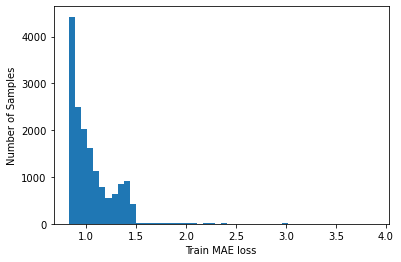

In [45]:
train_prediction = model.predict(X_train, verbose=0)
print(f"Train Prediction Shape: {train_prediction.shape}")
print(f"y Train Shape: {y_train.shape}")
train_mae_loss = np.mean(np.abs(train_prediction - y_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Test Prediction Shape: (4001, 1)
y Test Shape: (4001,)
Reconstruction error threshold: 1.8516019860777793


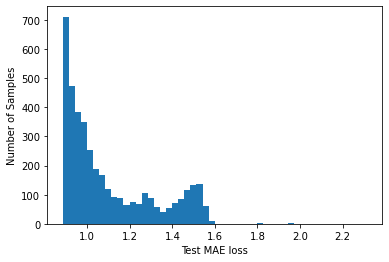

In [46]:
test_prediction = model.predict(X_test, verbose=0)
print(f"Test Prediction Shape: {test_prediction.shape}")
print(f"y Test Shape: {y_test.shape}")
test_mae_loss = np.mean(np.abs(test_prediction - y_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold = 0.8*np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

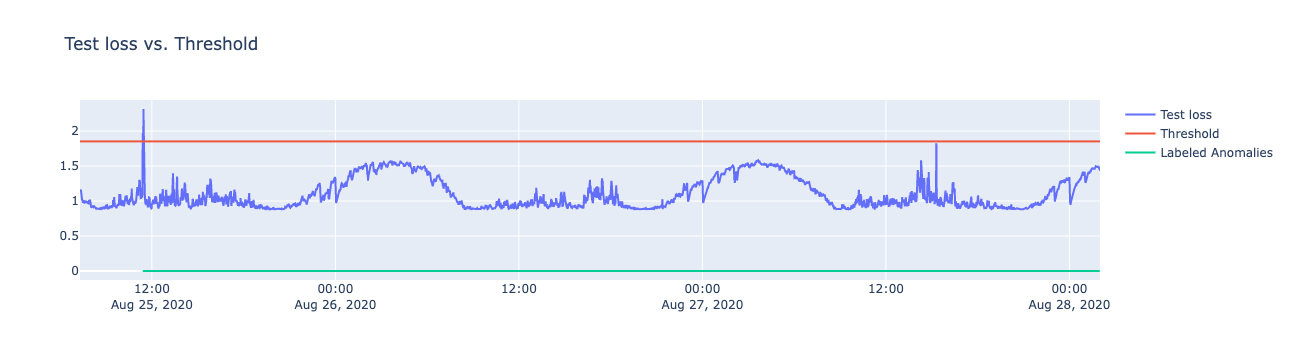

In [47]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['kpi_value'] = test[TIME_STEPS:]['kpi_value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.add_trace(go.Scatter(x=df['timestamp'][16404:20158], y=df['anomaly_label'], name='Labeled Anomalies'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [48]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(3, 7)

In [49]:
anomalies

timestamp  kpi_value  request_count  anomaly_label  \
16404 2020-08-25 11:24:00+02:00  -1.914213           8883              0   
16407 2020-08-25 11:27:00+02:00  -1.747245           9094              0   
16410 2020-08-25 11:30:00+02:00  -1.095062           9427              0   

           loss  threshold  anomaly  
16404  1.970201   1.851602     True  
16407  2.314502   1.851602     True  
16410  1.962088   1.851602     True

In [50]:
anomalies["anomaly"]

16404    True
16407    True
16410    True
Name: anomaly, dtype: bool

In [51]:
test_score_df['kpi_value']

16158    0.745866
16159    0.969825
16160    0.761534
16161    0.806545
16162    0.274841
           ...   
20154    1.274112
20155    1.321777
20156    1.327707
20157    1.343707
20158    1.089109
Name: kpi_value, Length: 4001, dtype: float64

In [52]:
test_score_df['kpi_value'].values.reshape(-1,1)

array([[0.74586607],
       [0.96982508],
       [0.76153355],
       ...,
       [1.32770665],
       [1.34370686],
       [1.08910908]])

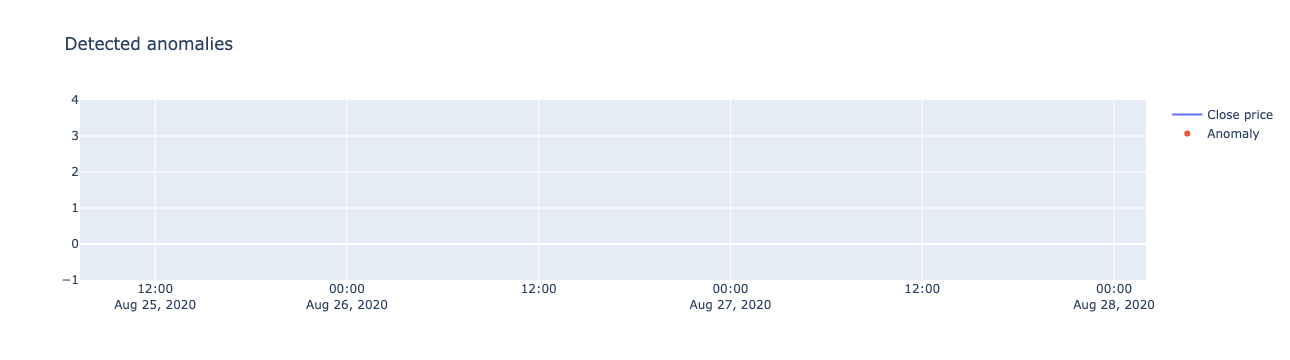

In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['kpi_value'].values.reshape(1,-1)), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['kpi_value'].values.reshape(1,-1)), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [54]:
loss=test_score_df['loss']
loss
threshold=test_score_df['threshold']
threshold.iloc[8]

1.8516019860777793

In [55]:
n=0
a=0

new_anomalies=[]

for i in range(len(test_score_df['loss'])):
    if test_score_df['loss'].iloc[i] <= test_score_df['threshold'].iloc[i]:
        n=n+1
        t=0
        new_anomalies.append(t)
    elif test_score_df['loss'].iloc[i] > test_score_df['threshold'].iloc[i]:
        a=a+1
        t=1
        new_anomalies.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 3998
Number of anomalies: 3


In [56]:
#new_anomalies

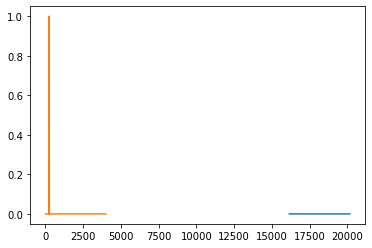

In [57]:
label=test_score_df['anomaly_label']
len(label)-len(new_anomalies)
plt.plot(label)
plt.plot(new_anomalies)

In [58]:
#new_anomalies

In [59]:
label

16158    0
16159    0
16160    0
16161    0
16162    0
        ..
20154    0
20155    0
20156    0
20157    0
20158    0
Name: anomaly_label, Length: 4001, dtype: int64

In [60]:
tp60m=0
fp60m=0
tn60m=0
fn60m=0
for i in range((len(label))):
    if new_anomalies[i] == 1 and label.iloc[i] == 1:
            tp60m=tp60m+1
    elif new_anomalies[i] == 1 and label.iloc[i] == 0:
            fp60m=fp60m+1
    elif new_anomalies[i] == 0 and label.iloc[i] == 1:
            fn60m=fn60m+1
    elif new_anomalies[i] == 0 and label.iloc[i] == 0:
            tn60m=tn60m+1

In [61]:
print("THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp60m}")
print(f"Number of False Positives: {fp60m}")
print(f"Number of True Negatives: {tn60m}")
print(f"Number of False Negatives: {fn60m}")
print("###################################")

THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 0
Number of False Positives: 3
Number of True Negatives: 3998
Number of False Negatives: 0
###################################


In [62]:
precision_60m=tp60m/(tp60m+fp60m)
print(f"Precision: {round(precision_60m,3)}")

recall_60m=tp60m/(tp60m+fn60m)
print(f"Recall: {round(recall_60m,3)}")

F1_Score_60m=(2*precision_60m*recall_60m)/(precision_60m+recall_60m)
print(f"F1 Score: {round(F1_Score_60m,3)}")

Precision: 0.0


ZeroDivisionError: division by zero

In [63]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision_60_2=precision_score(new_anomalies,label, average='macro')
print(f"Precision Using Sklearn: {round(precision_60_2,3)}")

recall_60_2=recall_score(new_anomalies,label, average='macro')
print(f"Recall Using Sklearn: {round(recall_60_2,3)}")

F1_Score_2=f1_score(new_anomalies,label, average='macro')
print(f"F1 Score Using Sklearn: {round(F1_Score_2,3)}")

Precision Using Sklearn: 0.5
Recall Using Sklearn: 0.5
F1 Score Using Sklearn: 0.5


/Users/khalidalnahyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

